In [1]:
from IPython import display
%matplotlib inline
import gymnasium as gym
import time

In [2]:
from PIL import Image
import numpy as np
def display_image(imageArray):
    display.display(Image.fromarray(np.array(imageArray),'RGB'),clear=True)

###Policy###


In [3]:

def softmax_theta_to_pi(theta):
    return np.exp(theta) / np.sum(np.exp(theta), axis=1, keepdims=True)

def get_next_acion(pi, state):
    return np.random.choice([0,1,2,3], p=pi[state,:])

def update_theta(theta, pi, s_a_history):
    eta = 0.1
    T = len(s_a_history) - 1
    [s_count, a_count] = theta.shape
    delta_theta = theta.copy()
    for i in range(s_count):
        for j in range(a_count):
            sa_i = [sa for sa in s_a_history if sa[0] == i]
            sa_ij = [sa for sa in s_a_history if sa == [i, j]]
            N_i = len(sa_i)
            N_ij = len(sa_ij)
            delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
    return theta + eta * delta_theta

def run_once(env,pi,s_a_history,initial_observation,show=False):
    observation = initial_observation
    while True:
      if show:
        time.sleep(0.1)
        img = env.render()
        display_image(img)
      action = get_next_acion(pi,observation) # take a random action
      s_a_history[-1][1] = action
      observation, reward, terminated, truncated, info = env.step(action) # take a random action
      s_a_history.append([observation, np.nan])
      if terminated:
        if show:
            time.sleep(0.3)
            img = env.render()
            display_image(img)
        break
      

def reset(env, theta):
      observation = env.reset()[0]
      s_a_history = [[observation, np.nan]]
      pi = softmax_theta_to_pi(theta)
      return observation, s_a_history, pi

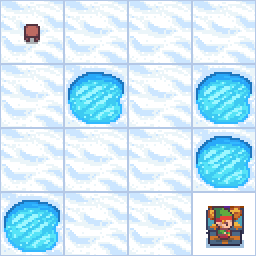

[[0.01819546 0.95087727 0.00926771 0.02165956]
 [0.40812413 0.12407565 0.21986792 0.2479323 ]
 [0.24171281 0.32404063 0.20432135 0.22992521]
 [0.26777917 0.23663643 0.25261911 0.24296529]
 [0.01296313 0.9703159  0.00438077 0.0123402 ]
 [0.25       0.25       0.25       0.25      ]
 [0.17932093 0.43900187 0.17932093 0.20235628]
 [0.25       0.25       0.25       0.25      ]
 [0.01936705 0.00466625 0.96496367 0.01100303]
 [0.02141412 0.1709977  0.80080657 0.00678162]
 [0.0132293  0.9728174  0.00608963 0.00786368]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.01462385 0.052374   0.9028141  0.03018805]
 [0.01069861 0.01893727 0.95771317 0.01265094]
 [0.25       0.25       0.25       0.25      ]]


In [8]:

env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=False, map_name='4x4')
theta_0 = np.ones((16, 4))

for k in range(10000):
   observation, s_a_history, pi = reset(env, theta_0)
   run_once(env,pi,s_a_history,observation,show=False)
   if s_a_history[-1][0] == 15:
      theta_0 = update_theta(theta_0, pi, s_a_history)
observation, s_a_history, pi = reset(env, theta_0)
run_once(env,pi,s_a_history,observation,show=True)
env.close()
print(pi)


Value

In [123]:
def simple_convert_theta_to_pi(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

def get_action(s, Q, espilon, pi):
    if np.random.rand() < espilon:
        return np.random.choice([0, 1, 2, 3], p=pi[s, :])
    else:
        return np.nanargmax(Q[s, :])
    
def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 15 or s_next == 5 or s_next == 7 or s_next == 11 or s_next == 12:
        Q[s, a] = Q[s, a] + eta * (r- Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])
    return Q

def run_once(env, s_a_history,initial_observation, Q, epsilon, eta, gamma, pi, show=False):
    observation = initial_observation
    s = observation
    a = get_action(s, Q, epsilon, pi)
    a_next = a
    while True:
        if show:
            time.sleep(0.3)
            img = env.render()
            display_image(img)
        a = a_next
        s_a_history[-1][1] = a
        s_next, reward, terminated, truncated, info = env.step(a)
        s_a_history.append([s_next, np.nan])
        if s_next == 15:
            r = 1
            a_next = np.nan
        # elif s_next == 5 or s_next == 7 or s_next == 11 or s_next == 12:
        #     r = -1
        #     a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        if terminated:
            if show:
                time.sleep(0.3)
                img = env.render()
                display_image(img)
            break
        else:
            s = s_next
    return [s_a_history, Q]


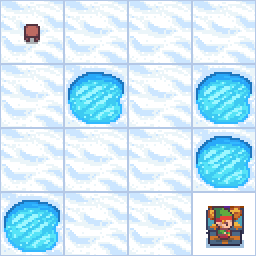

In [125]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=False, map_name='4x4')
theta_0 = np.ones((16, 4))


eta = 0.1
gamma = 0.9
epsilon = 0.5
Q = np.random.rand(16,4)
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

while is_continue:
    observation, s_a_history, pi = reset(env, theta_0)
    print('episode: ' + str(episode))
    espilon = epsilon / 2
    [s_a_history, Q] = run_once(env, s_a_history, observation, Q, epsilon, eta, gamma, pi)
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    episode = episode + 1
    if episode > 10000:
        break
observation, s_a_history, pi = reset(env, theta_0)
run_once(env, s_a_history, observation, Q, 0, eta, gamma, pi, show=True)
env.close()